In [1]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/charlesmiller/.local/share/virtualenvs/DL_experiments-uYdK1qgD/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [4]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).to(device)
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        s_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [5]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [6]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).to(device)
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).to(device)
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [7]:
data = pd.read_csv("nasdaq100_padding.csv")

In [8]:
data.shape

(40560, 82)

In [9]:
data.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


<Axes: >

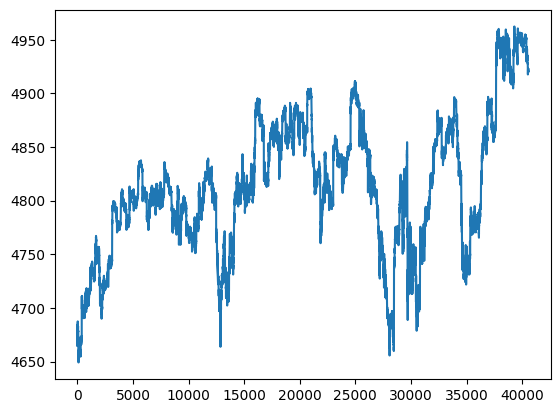

In [10]:
data["NDX"].plot()

In [11]:
batch_size = 128
timesteps = 16
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [12]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [13]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [14]:
for j in range(timesteps):
    y[:, j, 0] = data["NDX"].shift(timesteps - j - 1).fillna(method="bfill")

In [15]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [16]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [17]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [18]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [19]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [20]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [21]:
X_train_t.shape

torch.Size([35100, 16, 81])

In [48]:
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [50]:
from torch.utils.data import TensorDataset, DataLoader
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=128)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Saving...
Iter:  0 train:  0.16888592843399472 val:  0.14245759018494583
mse:  1396.7649 mae:  29.79866


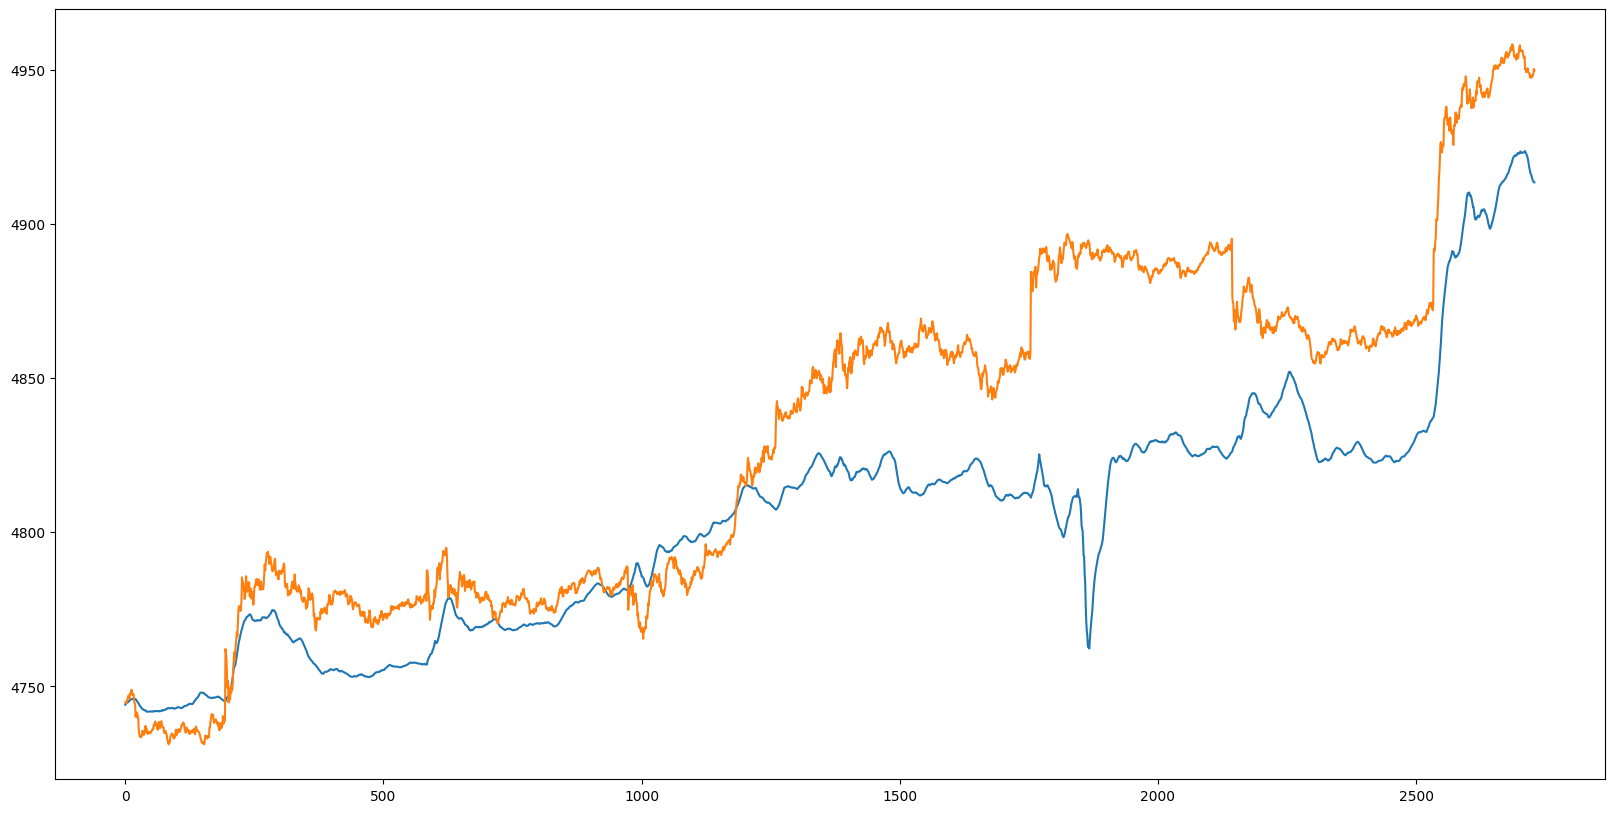

Saving...
Iter:  1 train:  0.03760621216375069 val:  0.06490204458007143
Saving...
Iter:  2 train:  0.0294772779189871 val:  0.05790300384356088
Saving...
Iter:  3 train:  0.023950328750464298 val:  0.03824062255178768
Saving...
Iter:  4 train:  0.019823856222825308 val:  0.021662945206064994
Saving...
Iter:  5 train:  0.016753569420647145 val:  0.020135293689067798
Saving...
Iter:  6 train:  0.015488602959061345 val:  0.014751362074138312
Iter:  7 train:  0.013881962547564986 val:  0.014757909879892674
Iter:  8 train:  0.013002776427041878 val:  0.021045391933144645
Saving...
Iter:  9 train:  0.012284420099231504 val:  0.01097347843628348
Saving...
Iter:  10 train:  0.011119302754158693 val:  0.010484191614608587
mse:  7.5652485 mae:  1.9965752


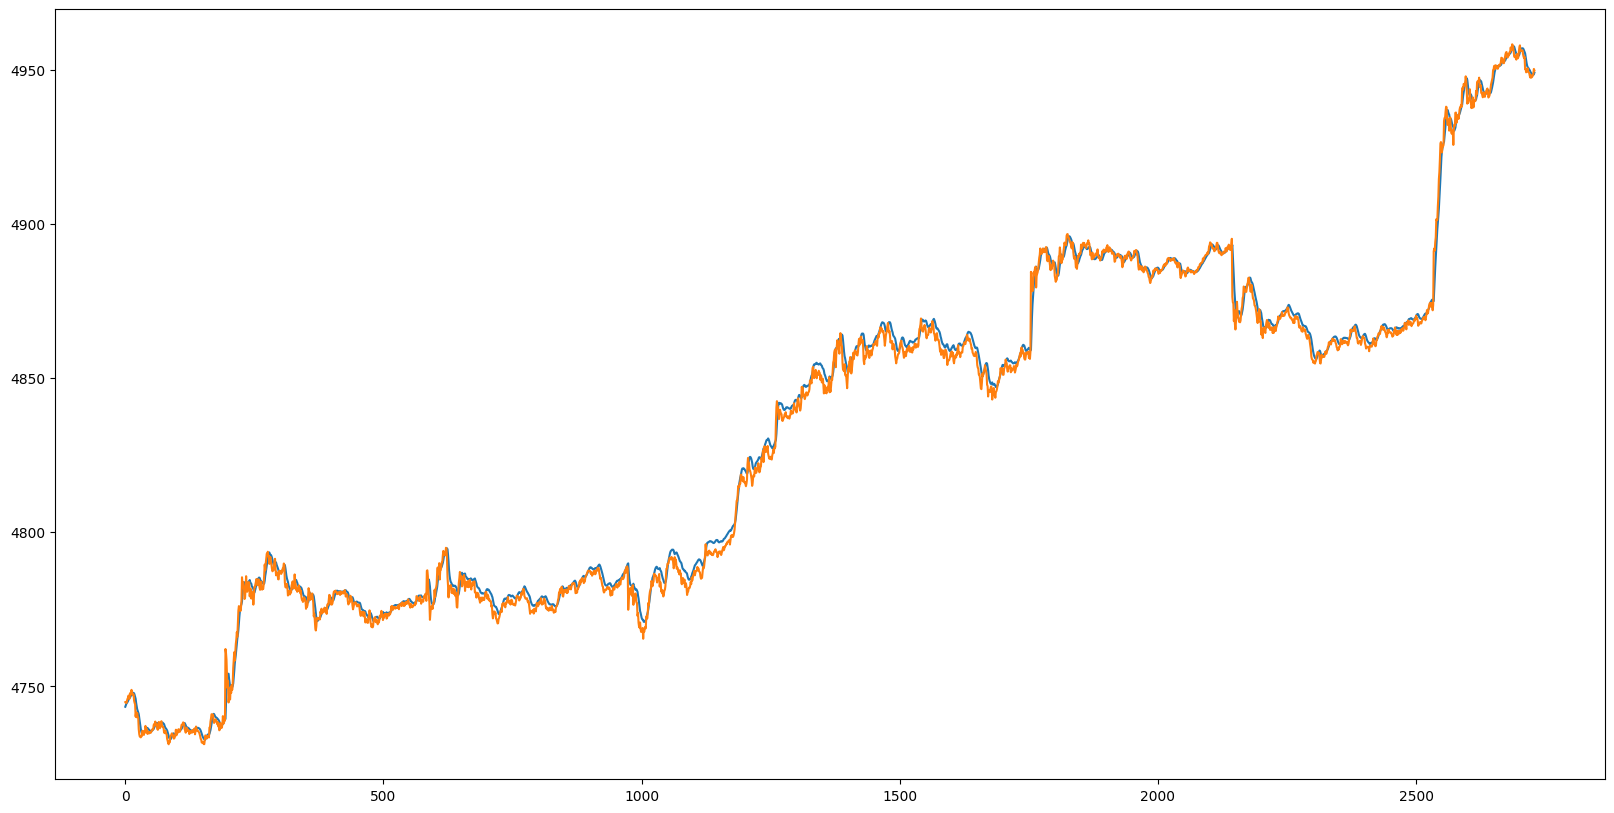

Saving...
Iter:  11 train:  0.010664828440218021 val:  0.009454354862128169
Iter:  12 train:  0.010110196017878135 val:  0.00965739199111293
Iter:  13 train:  0.009515635139675193 val:  0.011564663181626859
Saving...
Iter:  14 train:  0.010143972493079629 val:  0.008499202827107652
Iter:  15 train:  0.008826391592893194 val:  0.010134183540330287
Iter:  16 train:  0.009050543822311866 val:  0.009381820402782749
Iter:  17 train:  0.009253529842550411 val:  0.01106413905519141
Iter:  18 train:  0.008841360160758342 val:  0.009306645529865612
Saving...
Iter:  19 train:  0.00838627025803177 val:  0.007990496518622322
Saving...
Iter:  20 train:  0.008050610938361668 val:  0.007663245449574647
mse:  4.0418496 mae:  1.3737928


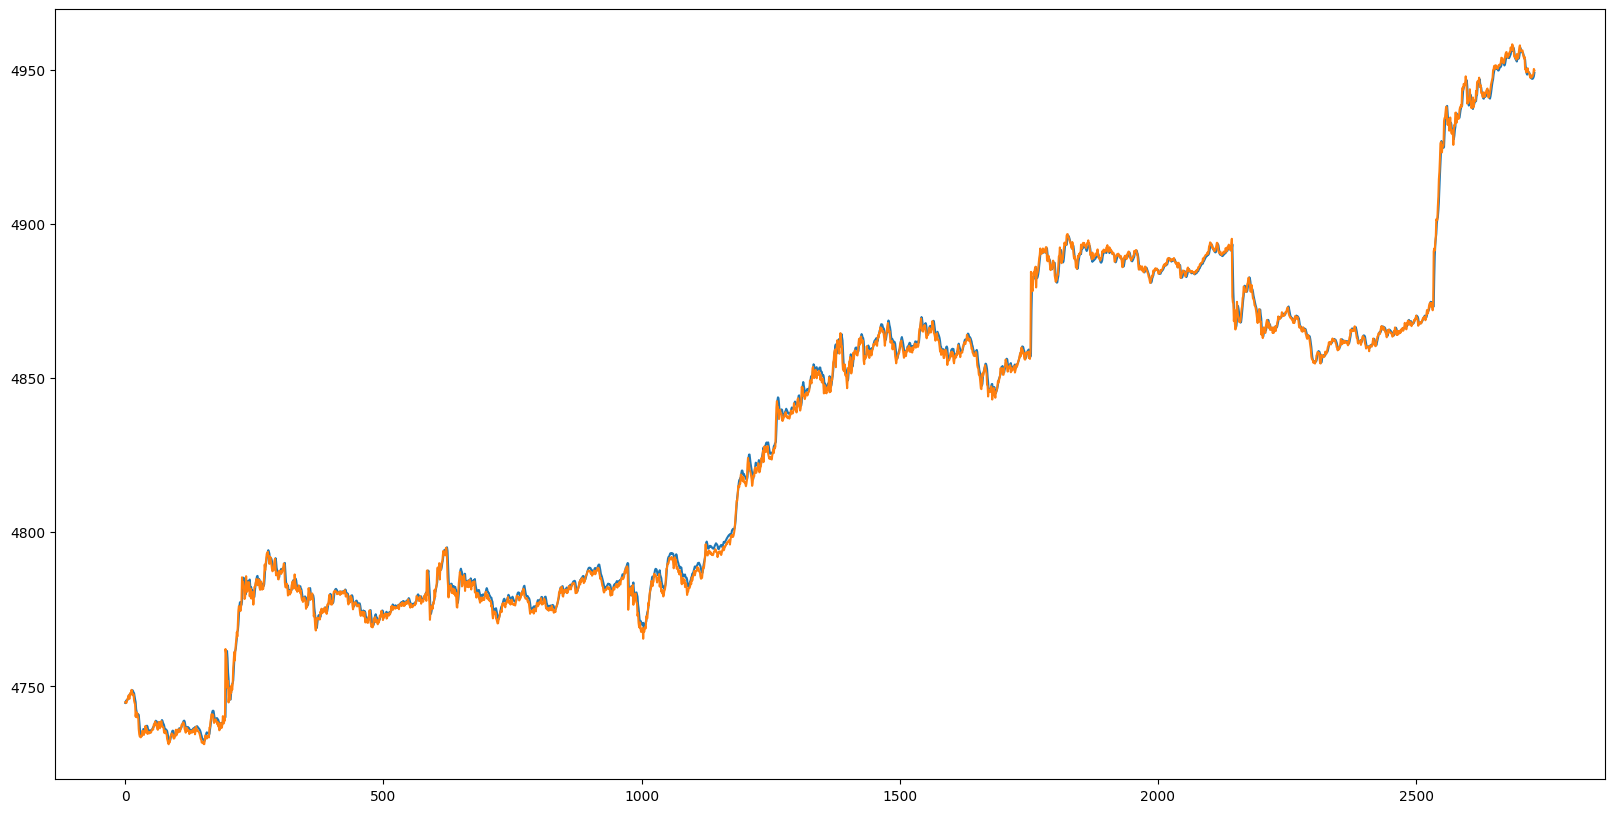

Iter:  21 train:  0.008236121819426031 val:  0.009046023198356873
Saving...
Iter:  22 train:  0.008153452677735758 val:  0.007478816472063546
Iter:  23 train:  0.007779717235166209 val:  0.009017972225059241
Saving...
Iter:  24 train:  0.008211075822358662 val:  0.007355703585223235
Iter:  25 train:  0.007436328705589247 val:  0.011549804926333052
Iter:  26 train:  0.007485717772480763 val:  0.010090724922654892
Iter:  27 train:  0.007475111968761488 val:  0.007368323783023969
Saving...
Iter:  28 train:  0.007405801421381123 val:  0.006389218486672364
Saving...
Iter:  29 train:  0.007092415223464618 val:  0.006344975876202672
Iter:  30 train:  0.007128296878906474 val:  0.008180624497857482
mse:  4.606003 mae:  1.6120391


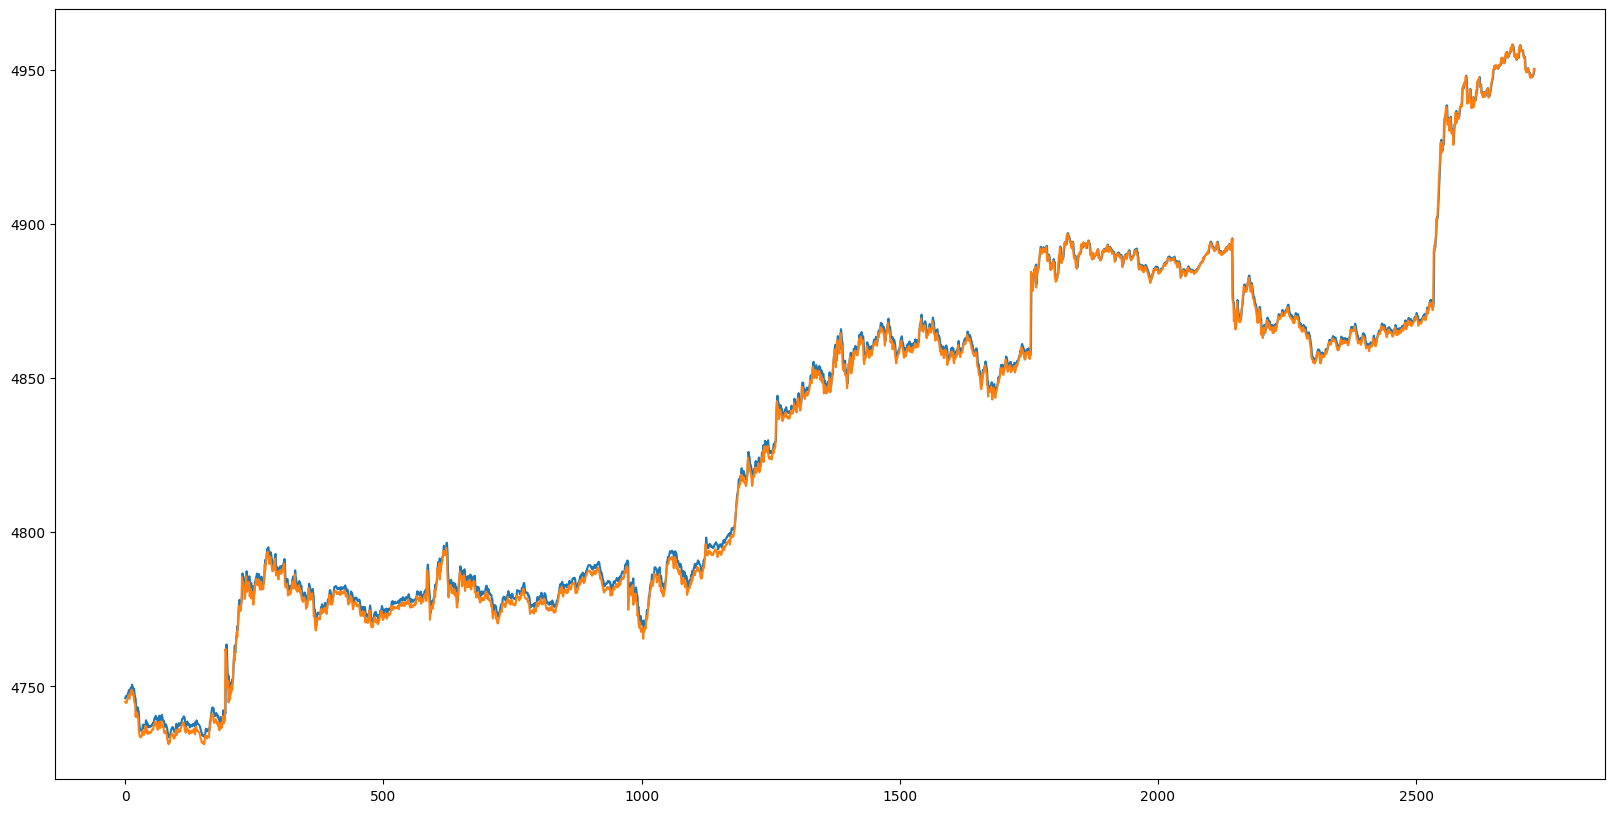

Iter:  31 train:  0.007156783873605915 val:  0.006817966698152025
Saving...
Iter:  32 train:  0.007188167827768302 val:  0.006265526649387334
Iter:  33 train:  0.007395822826927581 val:  0.00803392382238592
Iter:  34 train:  0.007171324419340681 val:  0.006457853075704075
Iter:  35 train:  0.007049405532721218 val:  0.008905078340549103
Iter:  36 train:  0.007190138072334832 val:  0.00786407688166103
Iter:  37 train:  0.006873186526944667 val:  0.00830268525041287
Iter:  38 train:  0.007260445981963636 val:  0.00821176982496542
Iter:  39 train:  0.007363726074201037 val:  0.007875076774066809
Iter:  40 train:  0.006792997768069934 val:  0.007147328821472901
mse:  3.515931 mae:  1.3240232


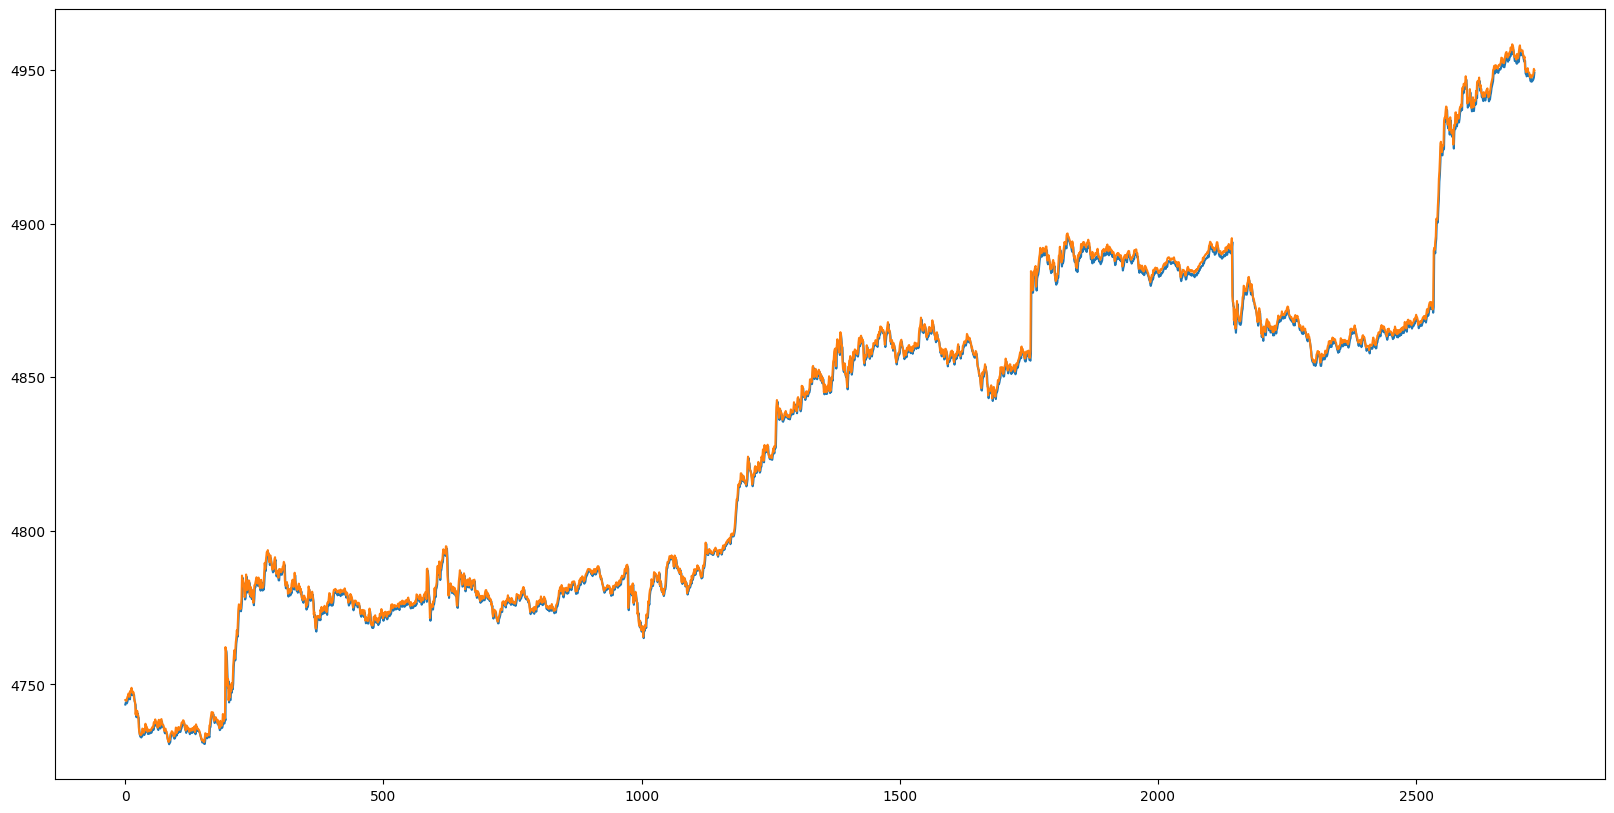

Iter:  41 train:  0.006863591266266763 val:  0.007050095917897729
Iter:  42 train:  0.006912060117211388 val:  0.007276016163266399
Iter:  43 train:  0.006955947342777331 val:  0.008544116395198146
Iter:  44 train:  0.006849055278916226 val:  0.007344742463491879
Iter:  45 train:  0.006951179139773876 val:  0.007527655763444507
Iter:  46 train:  0.006941068463629362 val:  0.0067622737411137165


In [52]:
epochs = 150
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_nasdaq.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()